In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./monthly_milk_production.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [3]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<Axes: xlabel='Date'>

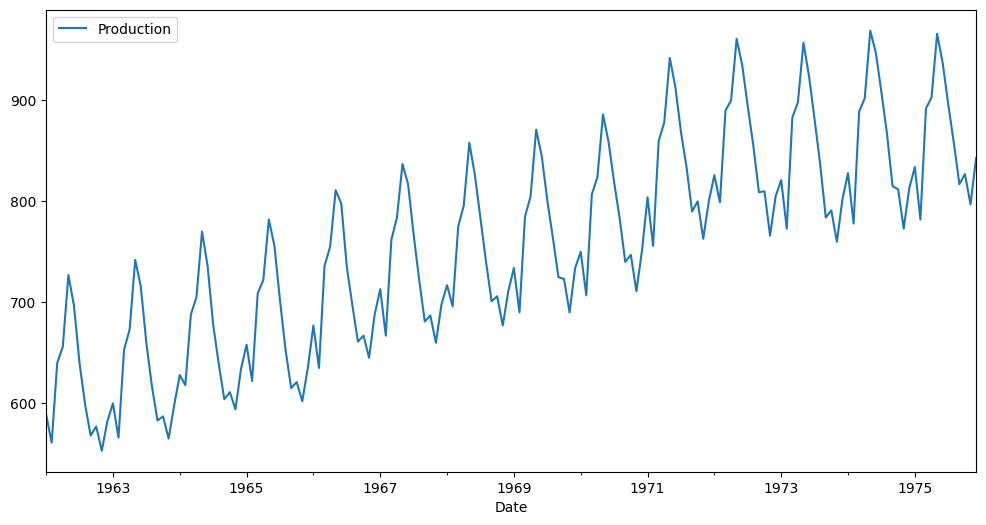

In [4]:
df.plot(figsize=(12,6))

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

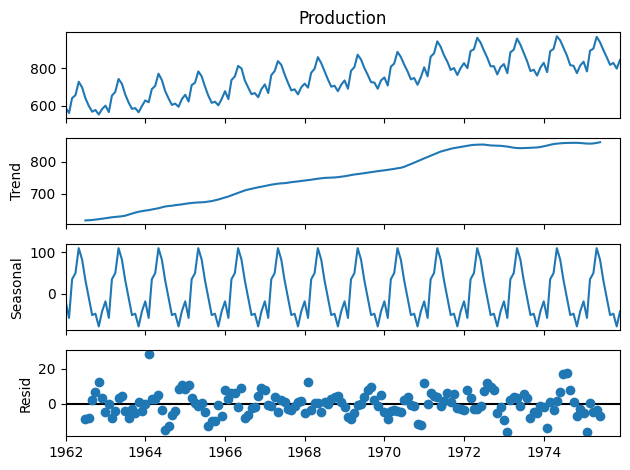

In [6]:
results = seasonal_decompose(df['Production'])
results.plot();

In [7]:
len(df)

168

In [8]:
train = df.iloc[:156]
test = df.iloc[156:]

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [10]:
df.head(),df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [11]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [12]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [13]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [14]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [15]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [16]:
X.shape

(1, 3, 1)

In [17]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [18]:
generator

In [19]:
for i,x in enumerate(generator):
    print(x)
    if i==1:
        break

(array([[[0.08653846],
        [0.01923077],
        [0.20913462],
        [0.24759615],
        [0.41826923],
        [0.34615385],
        [0.20913462],
        [0.11057692],
        [0.03605769],
        [0.05769231],
        [0.        ],
        [0.06971154]]]), array([[0.11298077]]))
(array([[[0.01923077],
        [0.20913462],
        [0.24759615],
        [0.41826923],
        [0.34615385],
        [0.20913462],
        [0.11057692],
        [0.03605769],
        [0.05769231],
        [0.        ],
        [0.06971154],
        [0.11298077]]]), array([[0.03125]]))


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [21]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MAE
from tensorflow.keras.activations import relu

In [22]:
# define model
model = Sequential()
model.add(Input(shape=(n_input, n_features)))
model.add(LSTM(100, activation=relu))
model.add(Dense(1))
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=MeanSquaredError(),
)

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
 18/144 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2466

d:\.venv_deep\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1096
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0245
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0174
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0137
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0133
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0064
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0083
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0060
Epoch 9/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049
Epoch 10/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0064
Epoch 11/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0034
Epoch 12/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0047
Epoch 13/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0044
Epoch 14/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0025
Epoch 15/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.00

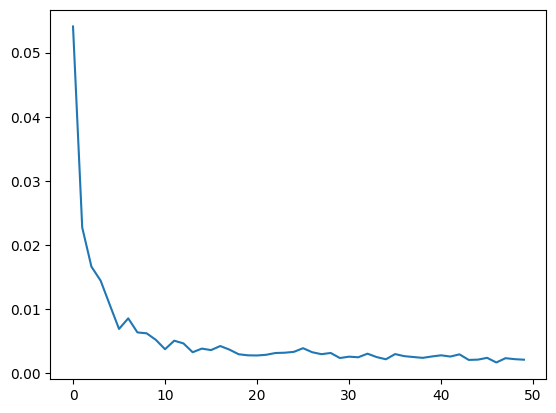

In [25]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [26]:
last_train_batch = scaled_train[-12:]

In [27]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [28]:
model.predict(last_train_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


array([[0.7046523]], dtype=float32)

In [29]:
scaled_test[0]

array([0.67548077])

In [30]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [31]:
test_predictions

[array([0.7046523], dtype=float32),
 array([0.6626213], dtype=float32),
 array([0.8630847], dtype=float32),
 array([0.9205148], dtype=float32),
 array([1.0362929], dtype=float32),
 array([1.0157828], dtype=float32),
 array([0.9391586], dtype=float32),
 array([0.8460983], dtype=float32),
 array([0.72172385], dtype=float32),
 array([0.69302315], dtype=float32),
 array([0.6296291], dtype=float32),
 array([0.67697203], dtype=float32)]

In [32]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [33]:
true_predictions = scaler.inverse_transform(test_predictions)

In [34]:
test.loc[:, "Predictions"] = true_predictions

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5236\3786560578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, "Predictions"] = true_predictions


<Axes: xlabel='Date'>

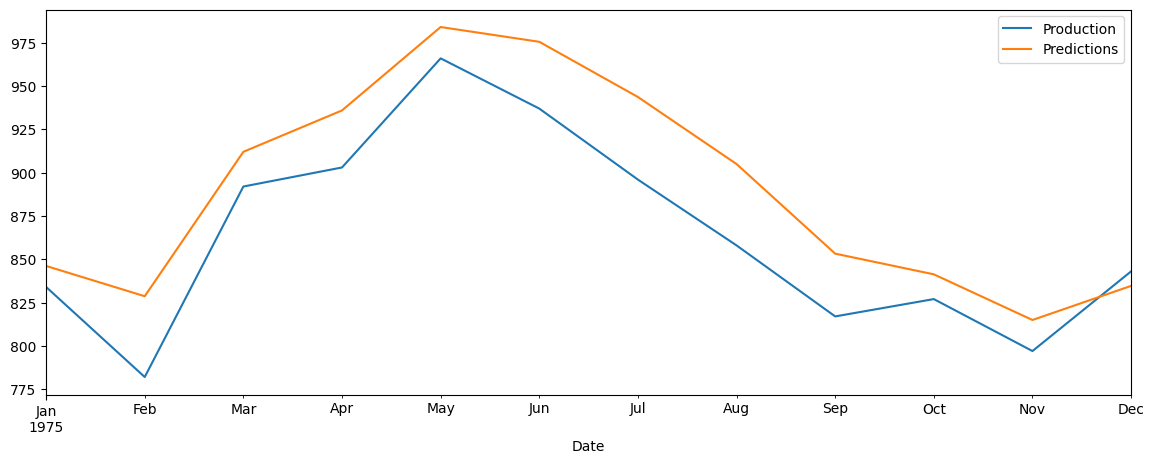

In [35]:
test.plot(figsize=(14,5))

In [36]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

31.64257286357649
